# Data Paths and Prep

In [232]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import sklearn.manifold as sklm
import os
from sklearn.decomposition import PCA
import scanpy as sc
import functions
importlib.reload(functions)
functions.set_user('Laila')

In [315]:
data = functions.call_data_clean()
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']

# Data Clean up and Normalization
---

### Check Data Sets after cleaning

In [318]:
# qc metrics
print(f"NaN in QC-metrics data set: {QC.isna().sum().sum()}")

# ATAC-seq
    # check for inf values
ATAC_inf = ATAC.isin([np.inf, -np.inf]).sum()
print(f"Infinite values in ATAC_seq: {ATAC_inf[ATAC_inf > 0].sum()}")

    # check for NaN values
print(f"NaN in ATAC_seq data set: {ATAC.isna().sum().sum()}")

print(len(QC))
print(len(ATAC.columns))
#print(ATAC)
#print(ATACtest.columns)
#print(ATACtest.index)
#print(ATACtest)
print(ATACtest.index[:10])
print(ATACtest.columns)
exons

NaN in QC-metrics data set: 5
Infinite values in ATAC_seq: 0
NaN in ATAC_seq data set: 760901
181
97
Index(['ImmGenATAC1219.peak_1', 'ImmGenATAC1219.peak_2',
       'ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4',
       'ImmGenATAC1219.peak_5', 'ImmGenATAC1219.peak_6',
       'ImmGenATAC1219.peak_7', 'ImmGenATAC1219.peak_8',
       'ImmGenATAC1219.peak_9', 'ImmGenATAC1219.peak_10'],
      dtype='object', name='ImmGenATAC1219.peakID')
Index(['chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb',
       'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM',
       'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM',
       'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp',
       'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp',
       'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th',
       'preT.DN3.Th', 'T.DN4.Th'

,Genname,ID,Chromosom,Strand,Transcription Start,Transcription End,CDS_Start,CDS_End,ExonCount,ExonStarts,ExonEnds,TSS
0,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3...",36136704
1,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3...",32151147
2,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294...",166254138
3,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,",156215926
4,Ostm1,NM_172416,chr10,+,42678915,42702462,42678983,42700538,6,"42678915,42683159,42692910,42696249,42698107,4...","42679397,42683274,42693008,42696417,42698273,4...",42678915
...,...,...,...,...,...,...,...,...,...,...,...,...
47376,Kcnc3,NR_169735,chr7,+,44590451,44604751,44604751,44604751,6,"44590451,44595160,44598380,44598805,44600673,4...","44591758,44596268,44598575,44598933,44600928,4...",44590451
47377,Kcnc3,NR_169736,chr7,+,44590451,44604751,44604751,44604751,6,"44590451,44595160,44598380,44598805,44600868,4...","44591758,44596268,44598575,44598933,44600928,4...",44590451
47378,Kcnc3,NR_169737,chr7,+,44590451,44604751,44604751,44604751,6,"44590451,44595160,44598383,44598805,44600868,4...","44591758,44596268,44598575,44598933,44600928,4...",44590451
47379,Ttn,NM_001385708,chr2,-,76703980,76982546,76705030,76980182,349,"76703980,76705669,76706439,76706696,76708158,7...","76705329,76705972,76706593,76707388,76708315,7...",76982546


In [222]:
exons
print(ATAC['chrom'].unique())

['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr1_GL456210_random' 'chr1_GL456211_random'
 'chr1_GL456212_random' 'chr1_GL456221_random' 'chr2' 'chr3' 'chr4'
 'chr4_GL456216_random' 'chr4_JH584292_random' 'chr4_JH584295_random'
 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chrUn_GL456239' 'chrUn_GL456359'
 'chrUn_GL456366' 'chrUn_GL456368' 'chrUn_GL456370' 'chrUn_GL456372'
 'chrUn_GL456378' 'chrUn_GL456383' 'chrUn_GL456387' 'chrUn_GL456389'
 'chrUn_GL456390' 'chrUn_GL456392' 'chrUn_GL456393' 'chrUn_GL456396'
 'chrUn_JH584304' 'chrX' 'chrX_GL456233_random' 'chrY']


# Exploratory Data
---

### Variance of peak signal

chr2: 29091 Peaks
chr1: 26616 Peaks
chr4: 22229 Peaks
chr5: 21814 Peaks
chr6: 21795 Peaks
chr11: 21732 Peaks
chr7: 20864 Peaks
chr10: 20455 Peaks
chr3: 19895 Peaks
chr9: 18784 Peaks
chr8: 17983 Peaks
chr13: 17515 Peaks
chr12: 15699 Peaks
chr17: 15612 Peaks
chr14: 14947 Peaks
chr15: 14911 Peaks
chr16: 13352 Peaks
chr18: 12198 Peaks
chr19: 9868 Peaks
chrX: 7329 Peaks
chrUn_JH584304: 162 Peaks
chrY: 64 Peaks
chrUn_GL456239: 38 Peaks
chr4_GL456216_random: 23 Peaks
chrX_GL456233_random: 18 Peaks
chrUn_GL456370: 14 Peaks
chr1_GL456210_random: 13 Peaks
chr4_JH584295_random: 4 Peaks
chrUn_GL456392: 3 Peaks
chrUn_GL456387: 3 Peaks
chrUn_GL456372: 3 Peaks
chr1_GL456212_random: 2 Peaks
chrUn_GL456366: 2 Peaks
chrUn_GL456378: 2 Peaks
chrUn_GL456389: 2 Peaks
chr1_GL456211_random: 1 Peaks
chrUn_GL456396: 1 Peaks
chrUn_GL456383: 1 Peaks
chrUn_GL456359: 1 Peaks


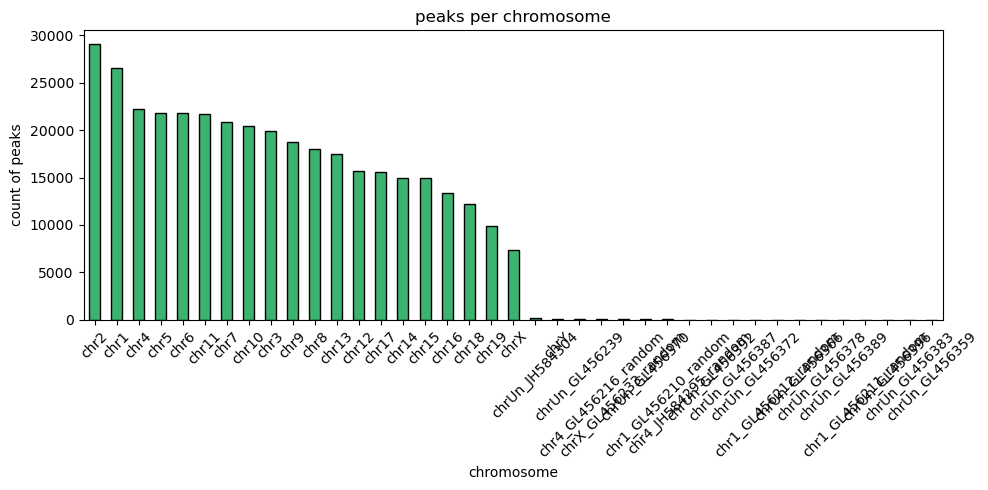

In [271]:
# counts of peaks per chromosome
chrom_counts = ATAC["chrom"].value_counts().sort_values(ascending=False)
peak_list = list(zip(chrom_counts.index, chrom_counts.values))
for chrom, count in peak_list:
    print(f"{chrom}: {count} Peaks")

plt.figure(figsize=(10,5))
chrom_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title("peaks per chromosome")
plt.xlabel("chromosome")
plt.ylabel("count of peaks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [319]:
# ATAC w/ additional data

from scipy.spatial import cKDTree
exons['TSS'] = np.where(exons['Strand'] == '+',
                        exons['Transcription Start'],
                        exons['Transcription End'])
distance_list = []
gene_list = []

for chrom in ATAC['chrom'].unique():
    #print(f"Verarbeite Chromosom: {chrom}")

    # Peaks auf diesem Chrom
    peaks_chr = ATAC[ATAC['chrom'] == chrom]
    peaks_pos = peaks_chr['Summit'].values

    # TSS-Koordinaten und Gen-Namen auf diesem Chrom
    exons_chr = exons[exons['Chromosom'] == chrom]
    tss_pos = exons_chr['TSS'].values
    gene_names = exons_chr['Genname'].values

    if len(tss_pos) > 0:
        # KDTree
        tree = cKDTree(tss_pos.reshape(-1, 1))
        dist, idx = tree.query(peaks_pos.reshape(-1, 1), k=1)
        nearest_tss = tss_pos[idx]
        signed_dist = peaks_pos - nearest_tss
        distance_list.extend(signed_dist)
        gene_list.extend(gene_names[idx])
    else:
        distance_list.extend([np.nan] * len(peaks_pos))
        gene_list.extend([np.nan] * len(peaks_pos))

# bins
bins = [0, 300, 1000, 5000, 20000, 1e6]
labels = ["0-300", "300-1k", "1k-5k", "5k-20k", ">20k"]

# gene context: up/downstrem or intergenic
def assign_peak_location(row, exons):
    chrom = row['chrom']
    peak_pos = row['Summit']
    # Alle Gene auf diesem Chrom
    exons_chr = exons[exons['Chromosom'] == chrom]
    # Finde alle Gene, für die der Peak im Bereich liegt
    hits = exons_chr[(exons_chr['Transcription Start'] <= peak_pos) & (exons_chr['Transcription End'] >= peak_pos)]
    if not hits.empty:
        return 'genic'
    else:
        # Bestimme nächstgelegenes Gen
        if len(exons_chr) > 0:
            # Hier nehmen wir den TSS des nächsten Gens
            distances = abs(exons_chr['TSS'] - peak_pos)
            idx = distances.idxmin()
            tss = exons_chr.loc[idx, 'TSS']
            # Liegt Peak vor oder nach TSS?
            if peak_pos < tss:
                return 'upstream'
            else:
                return 'downstream'
        else:
            return 'intergenic'

ATAC_dis = ATAC.copy()
ATAC_dis['nearest_gene'] = gene_list
ATAC_dis['distance_to_TSS'] = distance_list
ATAC_dis['mean'] = ATAC_scores.mean(axis=1, numeric_only=True)
ATAC_dis['median'] = ATAC_scores.median(axis=1, numeric_only=True)
ATAC_dis['var'] = ATAC_scores.var(axis=1, numeric_only=True)
ATAC_dis['sd'] = ATAC_scores.std(axis=1, numeric_only=True)
ATAC_dis['variability'] = ATAC_dis['sd'] / (ATAC_dis['mean'] + 1e-6)
ATAC_dis['min'] = ATAC_scores.min(axis=1)
ATAC_dis['max'] = ATAC_scores.max(axis=1)
ATAC_dis['range'] = ATAC_dis['max'] - ATAC_dis['min']
ATAC_dis['skewness'] = ATAC_scores.apply(scipy.stats.skew, axis=1)
ATAC_dis['region_type'] = np.where(ATAC_dis['distance_to_TSS'].abs() < 300, 'Promoter', 'Enhancer')
ATAC_dis['TSS_bin'] = pd.cut(ATAC_dis['distance_to_TSS'].abs(), bins=bins, labels=labels, include_lowest=True)
ATAC_dis['gene_context'] = ATAC_dis.apply(lambda row: assign_peak_location(row, exons), axis=1)

#ATAC_scores = ATAC_dis.iloc[:,7:89]

#ATAC_dis = ATAC_dis[
    #(ATAC_dis['mean'] <= 5) &
    #(ATAC_dis['sd'] <= 2) &
    #(ATAC_dis['variability'] <= 2) &
    #(ATAC_dis['distance_to_TSS'].abs() <= 300)
#]
#print(ATAC_dis[['chrom', 'Summit', 'distance_to_TSS', 'nearest_gene']].head())

In [ ]:
# only once: label not identifiable enhancer/promoter as distal enhancer
ATAC_dis['TSS_bin'] = ATAC_dis['TSS_bin'].cat.add_categories(['distal enhancer'])
ATAC_dis['TSS_bin'] = ATAC_dis['TSS_bin'].fillna('distal enhancer')

In [341]:
print(len(ATAC_dis.index))
print(len(ATACtest))

512590
512595


In [342]:
ATAC_dis.to_csv("ATAC_dis_annotated.csv", index=True)

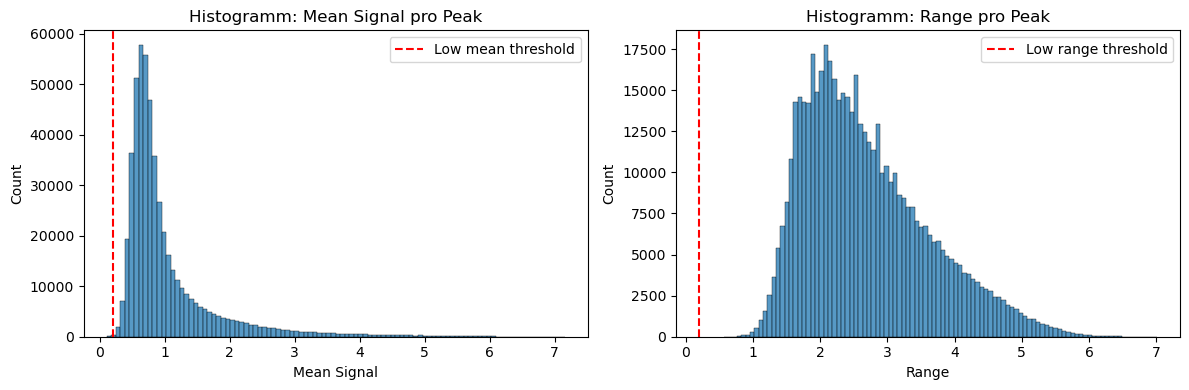

Peaks with low signal (mean < 0.2 und range < 0.2): 0 of 512590 peaks (0.00%)


In [255]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(ATAC_dis['mean'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low mean threshold')
plt.title("Histogramm: Mean Signal pro Peak")
plt.xlabel("Mean Signal")
plt.legend()

plt.subplot(1,2,2)
sns.histplot(ATAC_dis['range'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low range threshold')
plt.title("Histogramm: Range pro Peak")
plt.xlabel("Range")
plt.legend()
plt.tight_layout()
plt.show()

low_signal = ATAC_dis[(ATAC_dis['mean'] < 0.2) & (ATAC_dis['range'] < 0.2)]
n_low = len(low_signal)
total = len(ATAC_dis)
print(f"Peaks with low signal (mean < 0.2 und range < 0.2): {n_low} of {total} peaks ({n_low/total:.2%})")

No detectably low signal from ATAC-seq dataset.
Additional threshold for -log10pVal can be applied (e.g. >=1.3).

In [256]:
#data = functions.call_data_clean(p_threshold=1.3)
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']

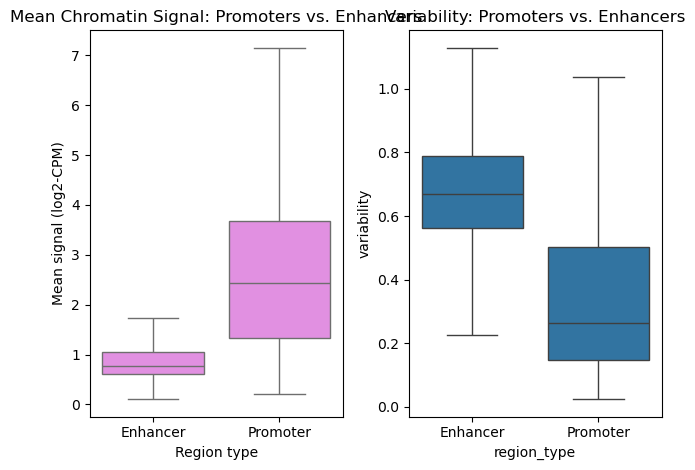

In [264]:
plt.subplot(1,2,1)
sns.boxplot(x='region_type', y='mean', data=ATAC_dis, color='violet', showfliers=False)
plt.title("Mean Chromatin Signal: Promoters vs. Enhancers")
plt.xlabel("Region type")
plt.ylabel("Mean signal (log2-CPM)")

plt.subplot(1,2,2)
sns.boxplot(x='region_type', y='variability', data=ATAC_dis, showfliers=False)
plt.title("Variability: Promoters vs. Enhancers")

plt.tight_layout()
plt.show()

If promoters are defined as everything with <300bp distance to a gene, a significant difference between enhancer/promoter can be seen in terms of peak signal.
Enhancer have a lower, more variable signal than promoters. To varify, a test test will be performed.

In [274]:
# mean testing
prom = ATAC_dis[ATAC_dis['region_type']=='Promoter']['mean']
enh = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['mean']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom, enh, equal_var=False)
print(f"T-test promoter vs enhancer mean: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")

#variability testing
prom2 = ATAC_dis[ATAC_dis['region_type']=='Promoter']['variability']
enh2 = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['variability']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom2, enh2, equal_var=False)
print(f"T-test promoter vs enhancer mean: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")


T-test promoter vs enhancer mean: t=188.73, p=0.0e+00
p < 1e-300 (close to 0, highly significant)
T-test promoter vs enhancer mean: t=-244.89, p=0.0e+00
p < 1e-300 (close to 0, highly significant)


## 3rd subquestion

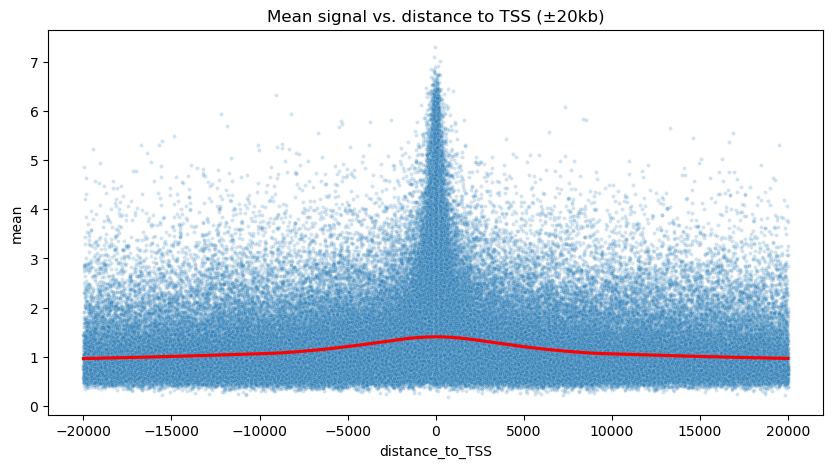

In [277]:
subset1 = ATAC_dis[ATAC_dis['distance_to_TSS'].abs() < 20000]
plt.figure(figsize=(10,5))
sns.scatterplot(x='distance_to_TSS', y='mean', data=subset1, alpha=0.2, s=8)
sns.regplot(x='distance_to_TSS', y='mean', data=subset1, scatter=False, lowess=True, color='red')
plt.title('Mean signal vs. distance to TSS (±20kb)')
plt.show()

visible, that the open chromatin regions lie at TSS most often (expected).

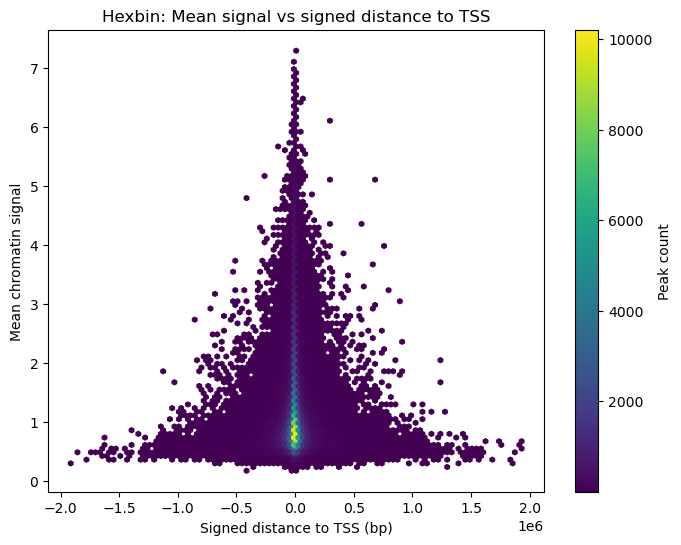

In [283]:
plt.figure(figsize=(8,6))
plt.hexbin(ATAC_dis['distance_to_TSS'], ATAC_dis['mean'], gridsize=100, cmap='viridis', mincnt=1)
plt.xlabel("Signed distance to TSS (bp)")
plt.ylabel("Mean chromatin signal")
plt.title("Hexbin: Mean signal vs signed distance to TSS")
plt.colorbar(label='Peak count')
plt.show()

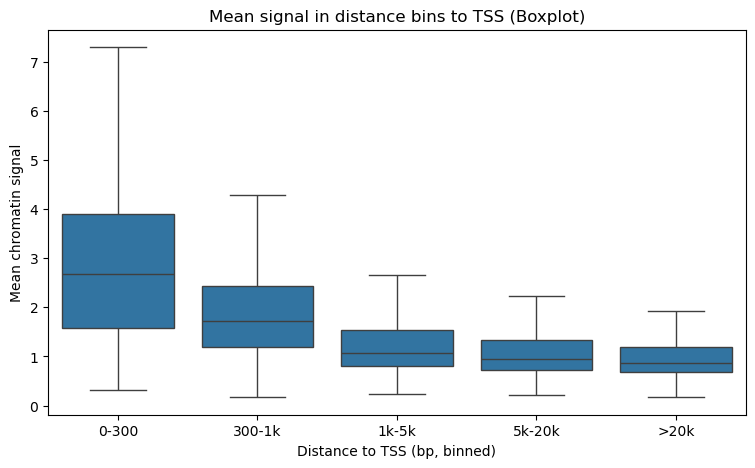

In [280]:
# box plot distance bins
plt.figure(figsize=(9,5))
sns.boxplot(x='TSS_bin', y='mean', data=ATAC_dis, showfliers=False)
plt.title("Mean signal in distance bins to TSS (Boxplot)")
plt.xlabel("Distance to TSS (bp, binned)")
plt.ylabel("Mean chromatin signal")
plt.show()

/var/folders/hf/p924smkx04g4y9vl6kh5yy4r0000gn/T/ipykernel_41004/496655109.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='TSS_bin', y='mean', data=ATAC_dis, scale='width')


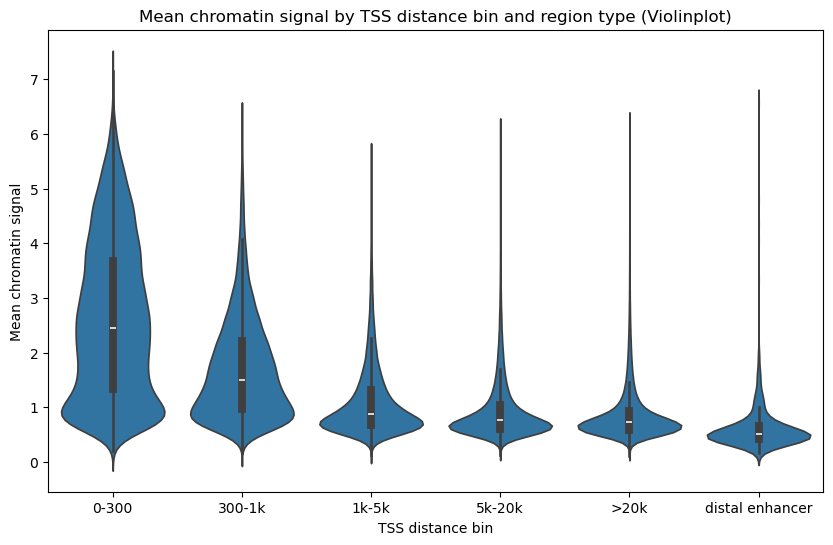

In [321]:
# vioplot distance bins
plt.figure(figsize=(10,6))
sns.violinplot(x='TSS_bin', y='mean', data=ATAC_dis, scale='width')
plt.title("Mean chromatin signal by TSS distance bin and region type (Violinplot)")
plt.xlabel("TSS distance bin")
plt.ylabel("Mean chromatin signal")
plt.show()

weshalb im 0-300 bin trotzden enhancer sein könnten:
a. Annotation kann komplex sein:
In komplexen Genomen gibt es oft mehrere TSS pro Gen, bidirektionale Promotoren, Überlappungen, oder nicht alle Peaks im 0–300-Bereich gehören funktionell zu einem Promotor.
b. Falsche/flexible Annotation:
Es kann Peaks geben, die zwar physisch nah am TSS liegen (also <300 bp), aber in der Annotation als „Enhancer“ markiert wurden – z.B. durch Überlappung mehrerer Feature-Datenbanken oder „multi-functional CREs“.
c. Alternativer oder antisense TSS:
Manche Regionen in der Nähe des TSS sind keine klassischen Promotoren, sondern könnten zu anderen Isoformen, Nachbargenen oder regulatorischen Regionen gehören.

## Analysis of ambiguous peaks

In [300]:
#print(sorted(ATAC_dis['TSS'].dropna().unique()))

['0610009L18Rik', '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610030E20Rik', '0610037L13Rik', '0610038B21Rik', '0610039K10Rik', '0610040F04Rik', '0610040J01Rik', '1010001N08Rik', '1110001J03Rik', '1110004E09Rik', '1110008F13Rik', '1110008L16Rik', '1110008P14Rik', '1110012L19Rik', '1110020A21Rik', '1110032F04Rik', '1110036E04Rik', '1110037F02Rik', '1110038B12Rik', '1110038F14Rik', '1110046J04Rik', '1110051M20Rik', '1110058D11Rik', '1110059E24Rik', '1110059G10Rik', '1110065P20Rik', '1190005I06Rik', '1190007I07Rik', '1300002E11Rik', '1500004A13Rik', '1500009L16Rik', '1500011B03Rik', '1500011K16Rik', '1500012K07Rik', '1500015O10Rik', '1600002H07Rik', '1600002K03Rik', '1600010M07Rik', '1600012H06Rik', '1600014C23Rik', '1600020E01Rik', '1600023N17Rik', '1600029I14Rik', '1700001C19Rik', '1700001D01Rik', '1700001G17Rik', '1700001K19Rik', '1700001L05Rik', '1700001L19Rik', '1700001O22Rik', '1700003D09Rik', '1700003F12Rik', '1700003G18Rik', '1700003M07Rik', '1700007G11Rik', '1700007J10Ri

In [338]:
ambiguous_peaks = ATAC_dis[(ATAC_dis['TSS_bin'] == '0-300') & (ATAC_dis['region_type'] == 'Enhancer')]
print(f"Es gibt {len(ambiguous_peaks)} solche 'Enhancer' im Promoter-Bin.")
display(ambiguous_peaks.head())
display(ATAC_dis[ATAC_dis['distance_to_TSS'].isna()])

# check on which genes no label of prom/enhancer can be made -> distal enhancer
print((ATAC_dis['TSS_bin']=='distal enhancer').sum())
nans = ATAC_dis[ATAC_dis['distance_to_TSS'].isna()]
print(nans['chrom'].value_counts())

ambiguous_genes = ambiguous_peaks['nearest_gene'].unique()
print(f"Betroffene Gene: {len(ambiguous_genes)} von {len(ATAC_dis['TSS'].dropna().unique())}")
print("Beispiel-Gene:", ambiguous_genes[:10])

chrom_counts = ambiguous_peaks['chrom'].value_counts().sort_index()
print("Anzahl ambiguous peaks pro Chromosom:")
print(chrom_counts)

Es gibt 61 solche 'Enhancer' im Promoter-Bin.


,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,...,var,sd,variability,min,max,range,skewness,region_type,TSS_bin,gene_context
ImmGenATAC1219.peakID,,,,,,,,,,,,,,,,,,,,,
ImmGenATAC1219.peak_5716,chr1,40790957,0.03,4.04,1.0,NaN,"Mfsd9,Tmem182",1.680462,2.754049,2.156850,...,0.233920,0.483653,0.207072,1.120502,3.524161,2.403659,0.041254,Enhancer,0-300,downstream
ImmGenATAC1219.peak_11076,chr1,71556855,0.01,23.68,1.0,NaN,"Atic,Fn1,Apol7d",3.991613,4.082518,3.776182,...,0.280324,0.529456,0.129152,2.175665,5.092504,2.916839,-0.884028,Enhancer,0-300,upstream
ImmGenATAC1219.peak_17337,chr1,98095946,0.07,3.81,1.0,NaN,"Pam,B230216N24Rik,1810006J02Rik",1.680462,2.754049,0.928022,...,0.429099,0.655057,0.323082,0.390562,3.848234,3.457673,-0.128260,Enhancer,0-300,downstream
ImmGenATAC1219.peak_31735,chr1,172590268,0.04,6.51,1.0,NaN,"Tagln2,Cfap45,4933439K11Rik,Vsig8,Slamf8,Fcrl6...",0.271312,0.068653,0.525201,...,0.619362,0.786996,0.816251,0.068653,3.221344,3.152691,1.105420,Enhancer,0-300,genic
ImmGenATAC1219.peak_37326,chr1,193173876,0.02,19.05,1.0,NaN,"Diexf,Irf6,A130010J15Rik,Traf3ip3,Hsd11b1,G0s2",2.180315,2.909988,3.402996,...,0.460250,0.678417,0.191585,1.759716,4.860108,3.100392,-0.342696,Enhancer,0-300,genic


,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,...,var,sd,variability,min,max,range,skewness,region_type,TSS_bin,gene_context
ImmGenATAC1219.peakID,,,,,,,,,,,,,,,,,,,,,
ImmGenATAC1219.peak_257409,chr1_GL456210_random,713,0.01,0.73,NaN,NaN,NaN,1.680462,0.428712,0.075426,...,0.206420,0.454335,0.736478,0.068692,2.543879,2.475187,1.496787,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257410,chr1_GL456210_random,4459,0.21,2.81,1.0,NaN,NaN,0.271312,0.068653,0.075426,...,0.546070,0.738965,0.991221,0.068653,2.992516,2.923864,1.386788,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257411,chr1_GL456210_random,4915,0.06,1.13,NaN,NaN,NaN,0.271312,0.068653,0.075426,...,0.181046,0.425495,0.855419,0.068653,1.828381,1.759728,1.397096,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257412,chr1_GL456210_random,7218,0.23,0.73,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.157325,0.396642,0.693809,0.068750,1.857888,1.789139,0.803135,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257413,chr1_GL456210_random,8378,0.14,3.47,1.0,NaN,NaN,0.271312,0.068653,0.075426,...,0.348938,0.590710,1.448354,0.068626,3.151335,3.082709,3.192870,Enhancer,distal enhancer,intergenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ImmGenATAC1219.peak_501834,chrUn_GL456393,52211,0.00,0.63,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.145718,0.381730,0.650487,0.068700,1.705670,1.636970,0.682258,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_501835,chrUn_GL456396,9911,0.00,0.72,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.137748,0.371145,0.777279,0.068626,1.974779,1.906153,1.478342,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_501836,chrUn_GL456396,12026,0.00,3.71,1.0,NaN,NaN,2.917500,3.055786,0.928022,...,0.376807,0.613846,0.490414,0.137300,3.245610,3.108310,0.993570,Enhancer,distal enhancer,intergenic


813
chrom
chrUn_GL456239          68
chr1_GL456210_random    41
chrUn_GL456370          23
chrUn_GL456378          12
chrUn_GL456387          11
chrUn_GL456372          10
chrUn_GL456383           8
chrUn_GL456393           7
chrUn_GL456389           6
chrUn_GL456392           6
chrUn_GL456390           5
chr4_JH584295_random     4
chrUn_GL456396           4
chrUn_GL456368           3
chrUn_GL456366           2
chrUn_GL456359           1
Name: count, dtype: int64


,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,...,var,sd,variability,min,max,range,skewness,region_type,TSS_bin,gene_context
ImmGenATAC1219.peakID,,,,,,,,,,,,,,,,,,,,,
ImmGenATAC1219.peak_257409,chr1_GL456210_random,713,0.01,0.73,NaN,NaN,NaN,1.680462,0.428712,0.075426,...,0.206420,0.454335,0.736478,0.068692,2.543879,2.475187,1.496787,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257410,chr1_GL456210_random,4459,0.21,2.81,1.0,NaN,NaN,0.271312,0.068653,0.075426,...,0.546070,0.738965,0.991221,0.068653,2.992516,2.923864,1.386788,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257411,chr1_GL456210_random,4915,0.06,1.13,NaN,NaN,NaN,0.271312,0.068653,0.075426,...,0.181046,0.425495,0.855419,0.068653,1.828381,1.759728,1.397096,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257412,chr1_GL456210_random,7218,0.23,0.73,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.157325,0.396642,0.693809,0.068750,1.857888,1.789139,0.803135,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_257413,chr1_GL456210_random,8378,0.14,3.47,1.0,NaN,NaN,0.271312,0.068653,0.075426,...,0.348938,0.590710,1.448354,0.068626,3.151335,3.082709,3.192870,Enhancer,distal enhancer,intergenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ImmGenATAC1219.peak_501834,chrUn_GL456393,52211,0.00,0.63,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.145718,0.381730,0.650487,0.068700,1.705670,1.636970,0.682258,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_501835,chrUn_GL456396,9911,0.00,0.72,NaN,NaN,NaN,0.271312,0.428712,0.075426,...,0.137748,0.371145,0.777279,0.068626,1.974779,1.906153,1.478342,Enhancer,distal enhancer,intergenic
ImmGenATAC1219.peak_501836,chrUn_GL456396,12026,0.00,3.71,1.0,NaN,NaN,2.917500,3.055786,0.928022,...,0.376807,0.613846,0.490414,0.137300,3.245610,3.108310,0.993570,Enhancer,distal enhancer,intergenic


Betroffene Gene: 61 von 13267
Beispiel-Gene: ['Mfsd9' 'Atic' 'Pam' 'Slamf8' 'A130010J15Rik' 'Txlnb' 'Gm33337' 'Pan2'
 'Sec61g' 'Rtn4']
Anzahl ambiguous peaks pro Chromosom:
chrom
chr1     5
chr10    3
chr11    9
chr12    3
chr13    2
chr15    2
chr16    1
chr17    5
chr18    1
chr19    2
chr2     8
chr3     2
chr5     3
chr6     3
chr7     5
chr8     4
chr9     3
Name: count, dtype: int64


In [327]:
print(ATAC_dis[ATAC_dis['distance_to_TSS']=='distal enhancer'])

Empty DataFrame
Columns: [chrom, Summit, mm10.60way.phastCons_scores, _-log10_bestPvalue, Included.in.systematic.analysis, TSS, genes.within.100Kb, LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MPP4.135+.BM, proB.CLP.BM, proB.FrA.BM, proB.FrBC.BM, preB.FrD.BM, B.FrE.BM, B1b.PC, B.T1.Sp, B.T2.Sp, B.T3.Sp, B.Sp, B.Fem.Sp, B.MZ.Sp, B.Fo.Sp, B.mem.Sp, B.GC.CB.Sp, B.GC.CC.Sp, B.PB.Sp, B.PC.Sp, B.PC.BM, preT.DN1.Th, preT.DN2a.Th, preT.DN2b.Th, preT.DN3.Th, T.DN4.Th, T.ISP.Th, T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve.Fem.Sp, T.8.Nve.Sp, T.4.Sp.aCD3+CD40.18hr, Treg.4.FP3+.Nrplo.Co, Treg.4.25hi.Sp, T8.TN.P14.Sp, T8.IEL.LCMV.d7.SI, T8.TE.LCMV.d7.Sp, T8.MP.LCMV.d7.Sp, T8.Tcm.LCMV.d180.Sp, T8.Tem.LCMV.d180.Sp, NKT.Sp, NKT.Sp.LPS.3hr, NKT.Sp.LPS.18hr, NKT.Sp.LPS.3d, Tgd.g2+d17.24a+.Th, Tgd.g2+d17.LN, Tgd.g2+d1.24a+.Th, Tgd.g2+d1.LN, Tgd.g1.1+d1.24a+.Th, Tgd.g1.1+d1.LN, Tgd.Sp, NK.27+11b-.BM, NK.27+11b+.BM, NK.27-11b+.BM, NK.27+11b-.Sp, NK.27+11b+.Sp, NK.27-11b+.Sp, ILC2.SI, ILC3.NKp46-CCR6-.SI, IL

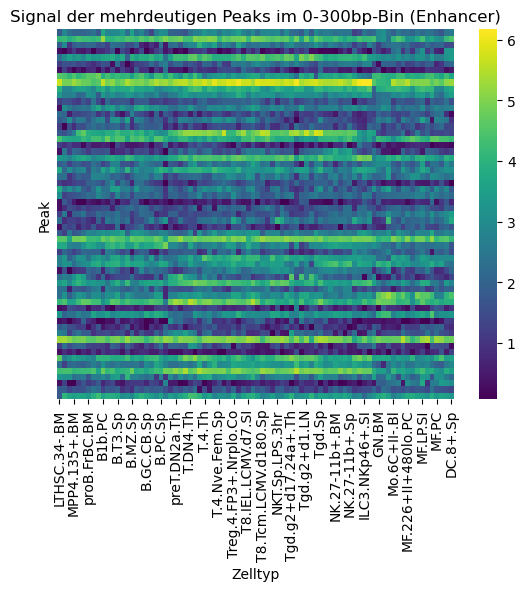

In [303]:
peak_signals = ambiguous_peaks.iloc[:, 7:89]
sns.heatmap(peak_signals, cmap="viridis", yticklabels=False)
plt.title("Signal der mehrdeutigen Peaks im 0-300bp-Bin (Enhancer)")
plt.xlabel("Zelltyp")
plt.ylabel("Peak")
plt.show()

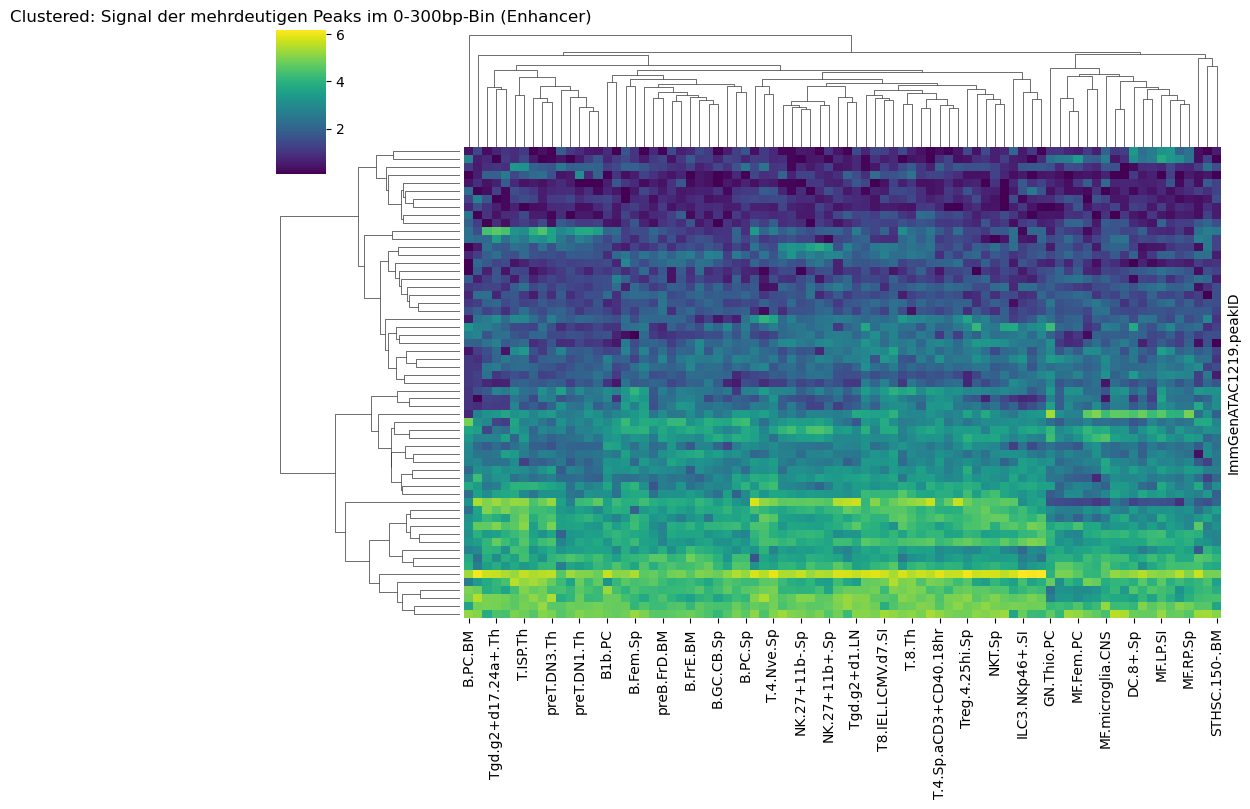

In [304]:
sns.clustermap(peak_signals, cmap="viridis", yticklabels=False, figsize=(10,8))
plt.title("Clustered: Signal der mehrdeutigen Peaks im 0-300bp-Bin (Enhancer)")
plt.show()

/var/folders/hf/p924smkx04g4y9vl6kh5yy4r0000gn/T/ipykernel_41004/3950638145.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 1].set_xticklabels(ATAC_dis['mean'].index, rotation=90)


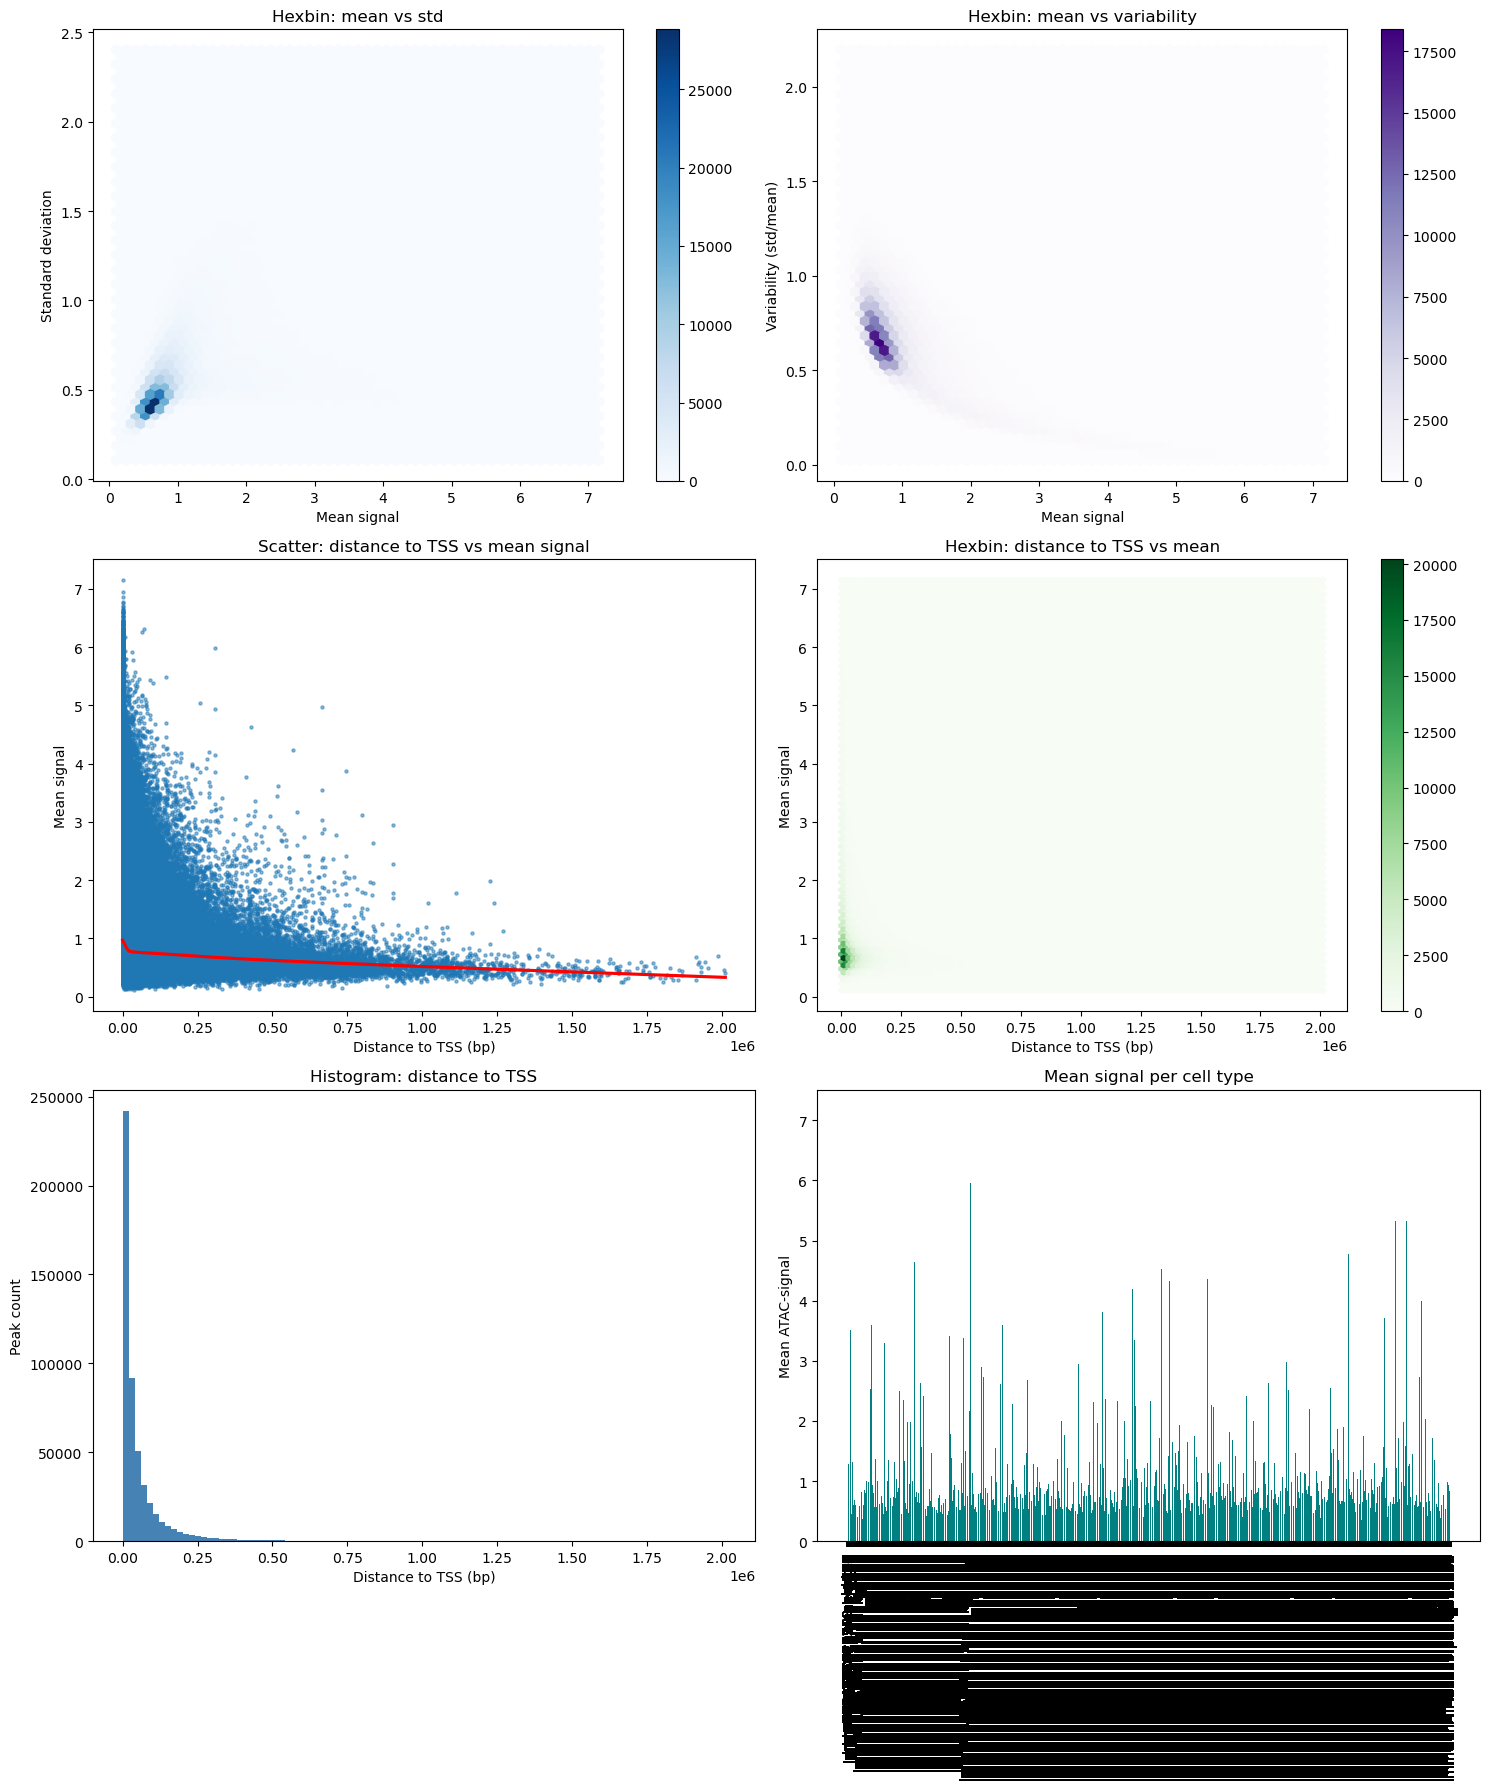

In [242]:
#subplot layout
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

## Plot 1: hexbin mean vs std
hb1 = axs[0, 0].hexbin(ATAC_dis['mean'], ATAC_dis['sd'], gridsize=50, cmap="Blues")
axs[0, 0].set_xlabel("Mean signal")
axs[0, 0].set_ylabel("Standard deviation")
axs[0, 0].set_title("Hexbin: mean vs std")
fig.colorbar(hb1, ax=axs[0, 0])

## Plot 2: hexbin mean vs variability
hb2 = axs[0, 1].hexbin(ATAC_dis['mean'], ATAC_dis['variability'], gridsize=50, cmap="Purples")
axs[0, 1].set_xlabel("Mean signal")
axs[0, 1].set_ylabel("Variability (std/mean)")
axs[0, 1].set_title("Hexbin: mean vs variability")
fig.colorbar(hb2, ax=axs[0, 1])

## Plot 3: scatter distance to TSS vs mean
axs[1, 0].scatter(ATAC_dis['distance_to_TSS'], ATAC_dis['mean'], s=5, alpha=0.5)
sns.regplot(x='distance_to_TSS', y='mean', data=ATAC_dis, scatter=False, lowess=True, ax=axs[1, 0], color="red")
axs[1, 0].set_xlabel("Distance to TSS (bp)")
axs[1, 0].set_ylabel("Mean signal")
axs[1, 0].set_title("Scatter: distance to TSS vs mean signal")

## Plot 4: hexbin distance to TSS vs mean
hb3 = axs[1, 1].hexbin(ATAC_dis['distance_to_TSS'], ATAC_dis['mean'], gridsize=100, cmap="Greens")
axs[1, 1].set_xlabel("Distance to TSS (bp)")
axs[1, 1].set_ylabel("Mean signal")
axs[1, 1].set_title("Hexbin: distance to TSS vs mean")
fig.colorbar(hb3, ax=axs[1, 1])

## Plot 5: histogram of distance to TSS
axs[2, 0].hist(ATAC_dis['distance_to_TSS'].dropna(), bins=100, color="steelblue")
axs[2, 0].set_xlabel("Distance to TSS (bp)")
axs[2, 0].set_ylabel("Peak count")
axs[2, 0].set_title("Histogram: distance to TSS")

## Plot 6: barplot mean signal per celltype
axs[2, 1].bar(ATAC_dis['mean'].index, ATAC_dis['mean'].values, color="teal")
#axs[2, 1].set_xticklabels(ATAC_dis['mean'].index, rotation=90)
axs[2, 1].set_ylabel("Mean ATAC-signal")
axs[2, 1].set_title("Mean signal per cell type")

plt.tight_layout()
plt.show()


In [343]:
display(ATAC_dis.head())

,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,...,var,sd,variability,min,max,range,skewness,region_type,TSS_bin,gene_context
ImmGenATAC1219.peakID,,,,,,,,,,,,,,,,,,,,,
ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.271312,0.428712,0.525201,...,0.165813,0.407201,0.754483,0.068554,1.826570,1.758017,0.939303,Enhancer,>20k,upstream
ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.271312,0.847423,0.525201,...,0.141103,0.375637,0.766608,0.068630,1.541715,1.473084,0.839625,Enhancer,>20k,upstream
ImmGenATAC1219.peak_3,chr1,3120109,0.07,10.80,1.0,NaN,NaN,1.131567,0.068653,0.525201,...,0.409753,0.640120,1.379892,0.068626,4.997333,4.928707,4.570317,Enhancer,>20k,upstream
ImmGenATAC1219.peak_4,chr1,3121485,0.15,3.02,1.0,NaN,NaN,0.271312,0.068653,0.075426,...,0.181010,0.425453,0.990038,0.068653,2.924184,2.855531,2.714369,Enhancer,>20k,upstream
ImmGenATAC1219.peak_5,chr1,3372787,0.03,1.31,NaN,NaN,NaN,0.271312,0.068653,0.075426,...,0.127097,0.356506,0.755765,0.068653,1.677193,1.608541,0.888782,Enhancer,>20k,genic


# Discriptive and Comparative Analysis

# Statistical Analysis and Regression Models